In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

excel = pd.ExcelFile("Code Mentor Data.xlsx")

In [2]:
mid_prices = pd.read_excel(excel, "mid_prices", header=None)
mid_prices.columns = ["Time", "MidPrice"]

In [3]:
tr = pd.read_excel(excel, "transactions", header=None, columns=["UID", "Volume", "Direction", "Price"])

In [4]:
tr.columns = ["UID", "Volume", "Direction", "Price"]

In [5]:
tr.head(10)

,UID,Volume,Direction,Price
0,5,1,0,100.00
1,18,1,1,99.95
2,19,3067,1,99.95
3,24,1,0,99.99
4,34,1,1,99.96
5,35,27455,1,99.95
6,54,1,1,99.96
7,55,1,1,99.96
8,56,1095,1,99.96
9,89,1,1,99.97


In [6]:
tr["Returns"] = tr["Price"].pct_change(1)
tr.head(10)

,UID,Volume,Direction,Price,Returns
0,5,1,0,100.00,NaN
1,18,1,1,99.95,-0.0005
2,19,3067,1,99.95,0.0000
3,24,1,0,99.99,0.0004
4,34,1,1,99.96,-0.0003
5,35,27455,1,99.95,-0.0001
6,54,1,1,99.96,0.0001
7,55,1,1,99.96,0.0000
8,56,1095,1,99.96,0.0000
9,89,1,1,99.97,0.0001


In [7]:
mid_prices.head(10)

,Time,MidPrice
0,1,99.97
1,2,99.97
2,3,99.97
3,4,99.97
4,5,99.97
5,6,99.97
6,7,99.97
7,8,99.97
8,9,99.98
9,10,99.98


In [8]:
mid_prices["Returns"] = mid_prices["MidPrice"].pct_change(1)
mid_prices.head(10)

,Time,MidPrice,Returns
0,1,99.97,NaN
1,2,99.97,0.0000
2,3,99.97,0.0000
3,4,99.97,0.0000
4,5,99.97,0.0000
5,6,99.97,0.0000
6,7,99.97,0.0000
7,8,99.97,0.0000
8,9,99.98,0.0001
9,10,99.98,0.0000


## Kurtosis Analysis

In [9]:
time = []
kurt = []

for lag in range(100):
    lagged_returns = mid_prices["MidPrice"].pct_change(lag)
    kurtosis = lagged_returns.kurt()
    kurt.append(kurtosis)
    time.append(lag)

# git rid of first observation since it is
# zero and Nan
time = time[1:]
kurt = kurt[1:]

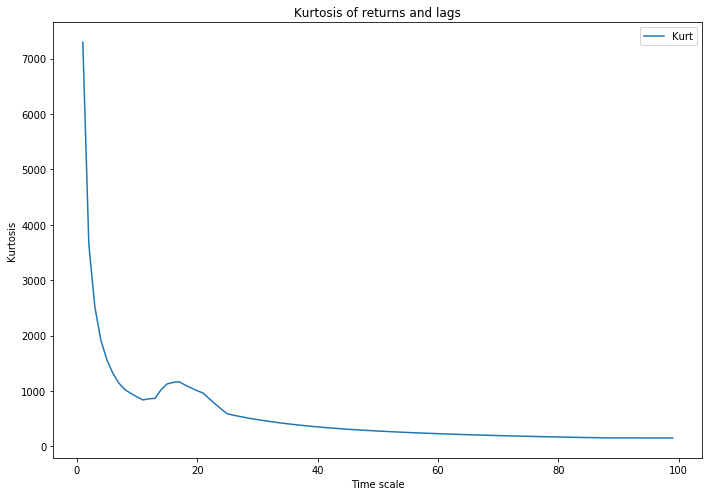

In [10]:
plt.figure(figsize=(10, 7))

plt.plot(time, kurt, label="Kurt")
plt.legend()
plt.xlabel("Time scale")
plt.ylabel("Kurtosis")
plt.title("Kurtosis of returns and lags")
plt.tight_layout()

## Hurst Coefficient Analysis

In [11]:
import hurst

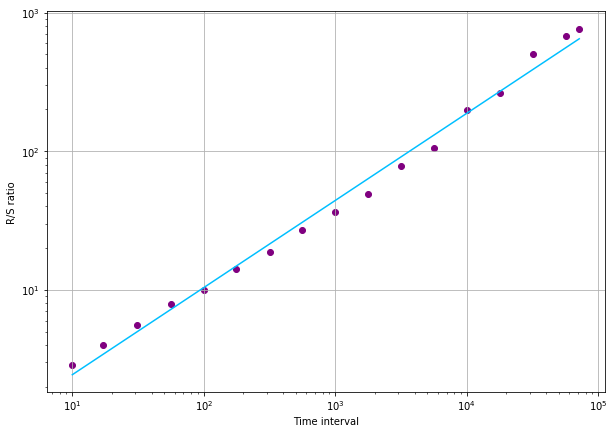

H=0.6288, c=0.5735


In [12]:
# Use random_walk() function or generate a random walk series manually:
# series = random_walk(99999, cumprod=True)
import numpy as np
from hurst import compute_Hc, random_walk
random_changes = 1. + np.random.randn(99999) / 1000.
series = np.cumprod(random_changes)  # create a random walk from random changes

# Evaluate Hurst equation
H, c, data = compute_Hc(mid_prices["MidPrice"], kind='random_walk', simplified=True)

# Plot

f, ax = plt.subplots(figsize=(10, 7))
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))


In [13]:
H, c, data = compute_Hc(mid_prices["MidPrice"], kind='price', simplified=True)

In [14]:
coeff_list = []

for lag in range(1, 200):
    H, c, data = compute_Hc(mid_prices["MidPrice"].pct_change(lag).dropna().abs(), 
                            kind='random_walk', simplified=True)
    coeff_list.append(H)

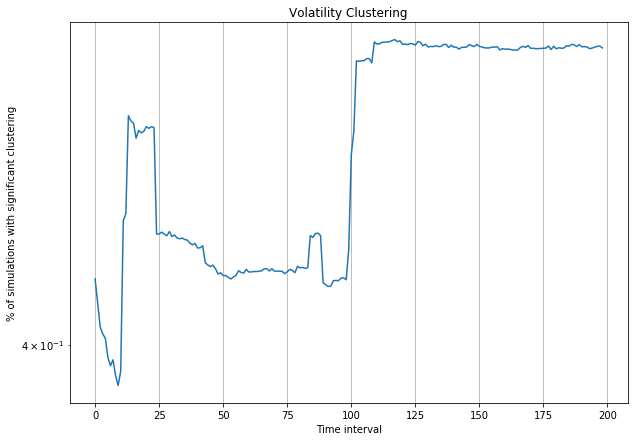

In [15]:
f, ax = plt.subplots(figsize=(10, 7))
plt.plot(np.arange(199), coeff_list)
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('% of simulations with significant clustering')
ax.grid(True)
plt.title("Volatility Clustering")
plt.show()


## Autocorrelation

In [16]:
def autocorrelation(x):
    result = np.correlate(x, x, mode='full')
    return result[int(len(result)/2):]

In [17]:
lag = 1
# first lag of returns of mid prices
returns_first_lag = mid_prices["Returns"]
returns_first_lag_ac = autocorrelation(returns_first_lag[2:])
# first lag of returns of transactions
tr_first_lag = tr["Returns"]
tr_first_lag_ac = autocorrelation(tr_first_lag[2:])

In [18]:
summary = pd.DataFrame(returns_first_lag_ac, columns=["MidPrices"])
summary.describe()

,MidPrices
count,7.148100e+04
mean,1.328323e-11
std,9.420039e-10
min,-2.000000e-08
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,2.099061e-07


In [19]:
summary = pd.DataFrame(tr_first_lag_ac, columns=["MidPrices"])
summary.describe()

,MidPrices
count,4.740800e+04
mean,1.695709e-09
std,9.543961e-07
min,-4.276971e-05
25%,-3.294567e-07
50%,-9.924628e-13
75%,3.292982e-07
max,1.579630e-04


## Long order memory flow

In [20]:
# first order lag autocorrelation of the order-sign
lag = 1
coeff = np.log(np.mean(autocorrelation(tr["Direction"])))
print("Coeff is:", coeff)

Coeff is: 8.524497104544734


In [21]:
# hurst exponent

H, c, data = compute_Hc(tr["Direction"].dropna().abs(), 
                            kind='random_walk', simplified=True)
print("Hurst coeff for order-sign is:", H)

Hurst coeff for order-sign is: -0.002348579799088424


## Concave Price impact

In [22]:
from sklearn.linear_model import LinearRegression


clf = LinearRegression()
clf.fit(tr["Volume"].values.reshape(-1, 1), tr["Price"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [23]:
clf.coef_

array([-2.18812607e-07])

In [24]:
tr["Volume"].describe()

count    47410.00000
mean      1775.29363
std       1314.30946
min          1.00000
25%        986.00000
50%       1183.00000
75%       2742.00000
max      27455.00000
Name: Volume, dtype: float64

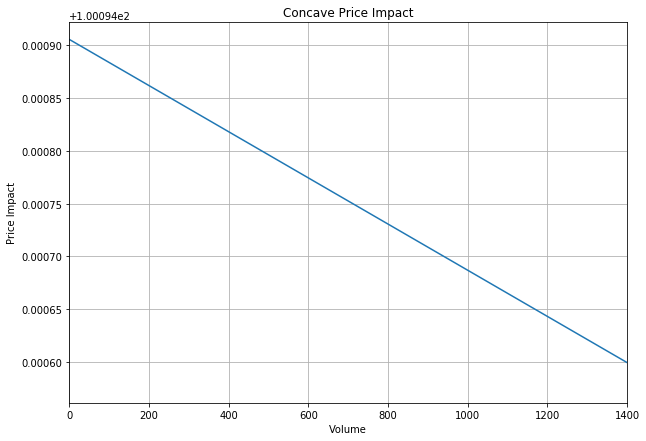

In [25]:

f, ax = plt.subplots(figsize=(10, 7))
plt.plot(np.arange(1, 1500), clf.coef_ * np.arange(1, 1500) + clf.intercept_)
ax.set_xlabel('Volume')
ax.set_ylabel('Price Impact')
ax.set_xlim((0, 1400))
ax.grid(True)
plt.title("Concave Price Impact")
plt.show()



In [27]:
mid_prices.head(20)

,Time,MidPrice,Returns
0,1,99.97,NaN
1,2,99.97,0.0000
2,3,99.97,0.0000
3,4,99.97,0.0000
4,5,99.97,0.0000
5,6,99.97,0.0000
6,7,99.97,0.0000
7,8,99.97,0.0000
8,9,99.98,0.0001
9,10,99.98,0.0000


## Extreme Price Events

In [30]:
mid_prices.iloc[0]["MidPrice"]

99.97

In [36]:
def is_extreme(position, df):
    """Returns true for a position if it consistently takes
    up/down position for 10 times before switching to the
    opposite and the net change is at least 0.8% of initial
    price"""
    initial_price = df.iloc[0]["MidPrice"]
    prices = df["MidPrice"].values
    curr_price = prices[position]
    increasing = True
    for i in range(position + 1, position + 10):
        if curr_price >= prices[i]:
            increasing = False
            break
    if increasing:
        delta = abs(prices[position] - prices[position + 10])
        if delta > initial_price * 0.08:
            return True
    decreaing = True
    for i in range(position + 1, position + 10):
        if curr_price <= prices[i]:
            decreaing = False
            break
    if decreaing:
        delta = abs(prices[position] - prices[position + 10])
        if delta > initial_price * 0.08:
            return True
    return False

In [47]:
# checking for working
for i in range(20 - 10):
    print(is_extreme(i, pd.DataFrame(np.arange(0, 20), columns=["MidPrice"])))

True
True
True
True
True
True
True
True
True
True


In [48]:
extreme_events = []
for i in range(len(mid_prices) - 10):
    if is_extreme(i, mid_prices):
        # save position
        extreme_events.append(i)

In [50]:
extreme_events

[]

For the current dataset, it appears there are no extreme events

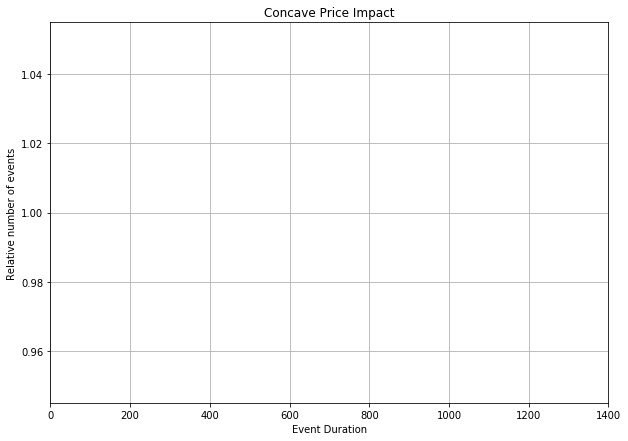

In [54]:
# assuming there is one event, just to plot
extreme_events = [1]
f, ax = plt.subplots(figsize=(10, 7))
plt.plot(np.arange(1), extreme_events)
ax.set_xlabel('Event Duration')
ax.set_ylabel('Relative number of events')
ax.set_xlim((0, 1400))
ax.grid(True)
plt.title("Concave Price Impact")
plt.show()

